In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
FOUNDATIONS = ["authority", "care", "fairness", "loyalty", "sanctity"]
COLORS = ["darkviolet", "mediumblue", "mediumseagreen", "indianred", "goldenrod"]

## Load dataset and predictions

In [3]:
data = pd.read_csv("mfd/data/mfd_scoring_results/mf_merged_roberta.csv", index_col=0)
data.drop(columns=["tokens"], inplace=True)
data.head(2)

,sentence,authority_label,authority_train,care_label,care_train,fairness_label,fairness_train,loyalty_label,loyalty_train,sanctity_label,...,care_fold,fairness_fold,loyalty_fold,sanctity_fold,none_fold,authority_score,care_score,fairness_score,loyalty_score,sanctity_score
0,"Betsy DeVos, President Trump's nominee for edu...",1,1,1,1,1,1,-1,-1,1,...,5,8,-1,7,10,0.832013,0.82923,0.731822,0.785273,0.668990
1,DeVos went on to write that she is 'eager to b...,1,1,0,1,1,1,-1,-1,1,...,5,2,-1,9,2,0.709451,0.62563,0.502918,0.471925,0.600735


In [4]:
def get_labels_and_scores(foundation, train=False, corpus="all"):
    assert corpus in ["twitter", "reddit", "news", "all"]
    if corpus == "news": data_f = data.iloc[:34262,:]
    elif corpus == "reddit": data_f = data.iloc[34262:34262 + 17886, :]
    elif corpus == "twitter": data_f = data.iloc[34262 + 17886:, :]
    else: data_f = data
    if train:
        # Labels and predicted scores for the training examples
        data_f = data_f[data_f[f"{foundation}_fold"] != 0]
        data_f = data_f[data_f[f"{foundation}_fold"] != -1]
    else:
        # Labels and predicted scores for the test examples
        data_f = data_f[data_f[f"{foundation}_fold"] == 0]
    y_true = data_f[f"{foundation}_label"]
    y_score = data_f[f"{foundation}_score"]
    return y_true, y_score

## Histograms of predicted scores

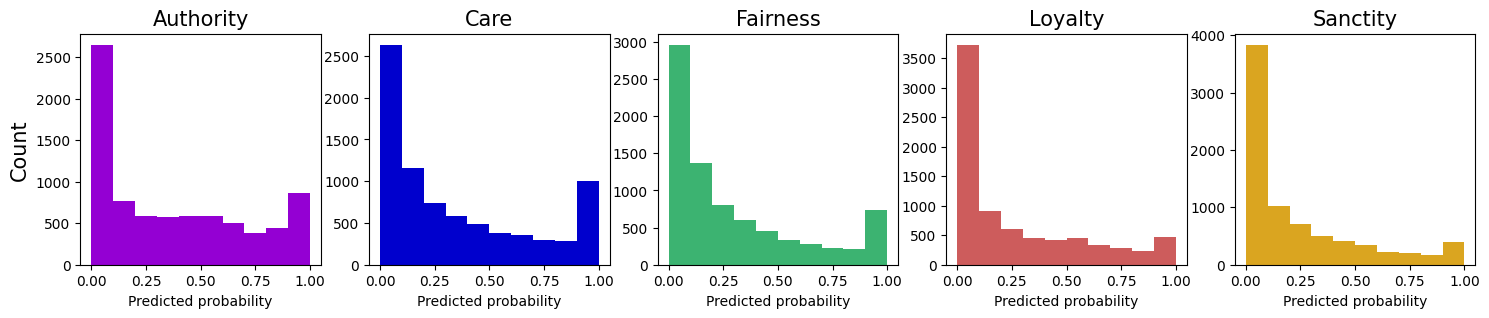

In [5]:
fig, axes = plt.subplots(1, len(FOUNDATIONS), figsize=(18, 3))
for ax, foundation, color in zip(axes, FOUNDATIONS, COLORS):
    # Get labels and predicted scores
    y_true, y_score = get_labels_and_scores(foundation, train=False)
    
    ax.hist(
        y_score,
        range=(0, 1),
        bins=10,
        label=foundation,
        color=color,
    )
    ax.set_title(foundation.capitalize(), size=15)
    ax.set(xlabel="Predicted probability")
axes[0].set_ylabel("Count", size=15)
plt.show()

## Calibration curve

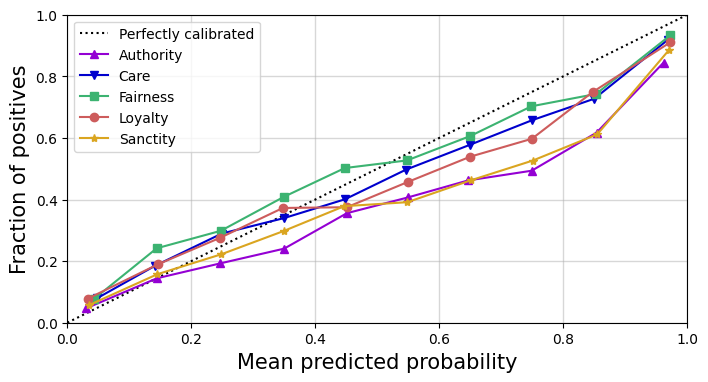

In [6]:
from sklearn.calibration import calibration_curve, CalibrationDisplay
MARKERS = ["^", "v", "s", "o", "*"]
n_bins = 10
fig, ax = plt.subplots(figsize=(8, 4))

# Perfect calibration
ax.plot([0, 1.0], [0, 1.0], c="k", linestyle="dotted", label="Perfectly calibrated")

for foundation, color, marker in zip(FOUNDATIONS, COLORS, MARKERS):
    # Get labels and predicted scores
    y_true, y_score = get_labels_and_scores(foundation, train=False)
    
    # Get fraction of pos and mean predicted prob
    prob_true, prob_pred = calibration_curve(y_true, y_score, n_bins=n_bins)
    ax.plot(prob_pred, prob_true, c=color, marker=marker, label=foundation.capitalize())


ax.set_xlim([0, 1.0])
ax.set_ylim([0, 1.0])
ax.grid(alpha=0.5, linestyle="-", linewidth=1)
ax.legend()
ax.set_xlabel("Mean predicted probability", size=15)
ax.set_ylabel("Fraction of positives", size=15)
plt.show()

## ROC curve: threshold-free, class prior independent

In [7]:
def plot_roc_curve(fpr, tpr, color, ax):
    ax.plot(fpr, tpr, lw=3, alpha=1, c=color)
    ax.plot([0, 1], [0, 1], linestyle='--', linewidth=2, c='k')
    ax.grid(alpha=0.5, linestyle=':', linewidth=2)
    
    # Customize x ticks
    ax.set_xticks(np.arange(0, 1.1, 0.1))
    ax.set_xticklabels(labels=list(map(lambda x: str(x)[1:3] if x < 1 else str(x)[0:2], np.arange(0, 1.1, 0.1))),
                       fontdict={"fontsize": "large"})
    
    # Customize y ticks
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    ax.set_yticklabels(labels=list(map(lambda x: str(x)[1:3] if x < 1 else str(x)[0:2], np.arange(0, 1.1, 0.1))),
                       fontdict={"fontsize": "large"})

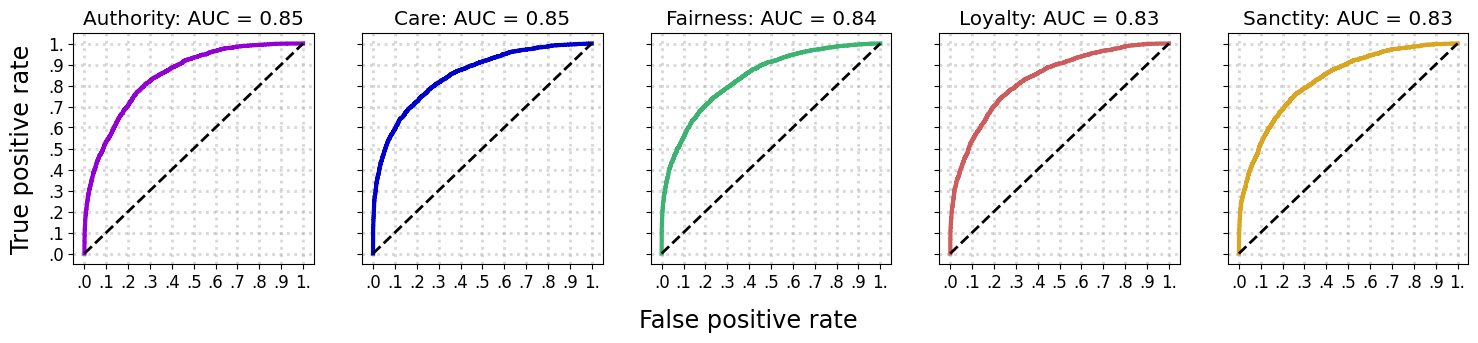

In [8]:
from utils.evaluation import evaluate_binary_scorer_fold
fig, axes = plt.subplots(1, len(FOUNDATIONS), figsize=(18, 3), sharey=True)

for foundation, color, ax in zip(FOUNDATIONS, COLORS, axes):
    # Get labels and predicted scores
    y_true, y_score = get_labels_and_scores(foundation, train=False)
    naive_y_pred = np.array([y >= 0.5 for y in y_score], dtype=int)
    
    results = evaluate_binary_scorer_fold(y_true=y_true, y_pred=naive_y_pred, y_score=y_score)
    roc = results["roc_curve"]
    
    plot_roc_curve(fpr=roc["fpr"], tpr=roc["tpr"], color=color, ax=ax)
    
    ax.set_title(f"{foundation.capitalize()}: AUC = {roc['auc']:.2f}", size="x-large")

fig.text(0.5, -0.04, "False positive rate", va="top", ha="center", size="xx-large")
axes[0].set_ylabel("True positive rate", size="xx-large", labelpad=10)
plt.show()

## Brier score: threshold-free, requires predicted scores to be probabilities

This is the MSE for binary prediction.

In [9]:
from sklearn.metrics import brier_score_loss
brier_scores = pd.Series(0, index=FOUNDATIONS)
for foundation, color, ax in zip(FOUNDATIONS, COLORS, axes):
    # Get labels and predicted scores
    y_true, y_score = get_labels_and_scores(foundation, train=False)
    
    brier_scores[foundation] = brier_score_loss(y_true=y_true, y_prob=y_score)

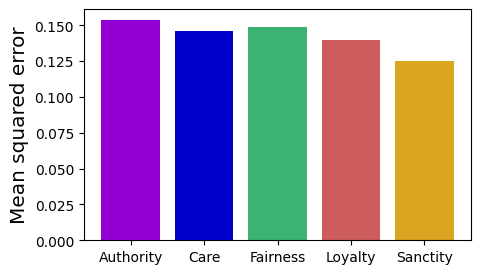

In [10]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.bar(brier_scores.index, brier_scores.values, color=COLORS)
ax.set_xticks(range(len(FOUNDATIONS)), [f.capitalize() for f in FOUNDATIONS])
ax.set_ylabel("Mean squared error", size="x-large")
plt.show()

## Thresholding to find binary predictions

- Where TPR and FPR differ the most (method 1)
- Top X% of the scores (method 2)

In [11]:
def threshold_max_diff(train_tpr, train_fpr, train_thresholds, y_test_score):
    optimal_idx = np.argmax(train_tpr - train_fpr)
    threshold = train_thresholds[optimal_idx]
    y_pred = [y >= threshold for y in y_test_score]
    return np.array(y_pred, dtype=int)

def threshold_top_x(x, y_test_score):
    assert 0 <= x and x <= 100
    threshold = np.percentile(y_test_score, q=x)
    y_pred = [y >= threshold for y in y_test_score]
    return np.array(y_pred, dtype=int)

What to measure:
- Num examples
- % positives (label prior)
- Accuracy
- Precision
- Recall
- F-1
- Likelihood ratio

In [12]:
# Binary prediction results
from utils.evaluation import evaluate_binary_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
    f1_score, class_likelihood_ratios, average_precision_score, matthews_corrcoef, \
    jaccard_score, roc_auc_score, balanced_accuracy_score

bin_pred_res = pd.DataFrame(0, index=FOUNDATIONS,
                            columns=["N", "%Pos", "Accuracy", "Balanced Acc", "Precision", "Recall", 
                                     "F1", "LR+", "Matthews", "Jaccard", "Avg Precision", 
                                     "AUROC"])
for foundation in FOUNDATIONS:
    y_train_true, y_train_score = get_labels_and_scores(foundation, train=True, corpus="all")
    y_test_true, y_test_score = get_labels_and_scores(foundation, train=False, corpus="all")
    
    bin_pred_res.loc[foundation, "N"] = len(y_test_true)
    bin_pred_res.loc[foundation, "%Pos"] = 100 * sum(y_test_true) / len(y_test_true)
    
    naive_y_train_pred = np.array([y >= 0.5 for y in y_train_score], dtype=int)
    train_results = evaluate_binary_scorer_fold(y_pred=naive_y_train_pred, 
                                                y_score=y_train_score, 
                                                y_true=y_train_true)
    
    # METHOD 1
    y_test_pred = threshold_max_diff(y_test_score=y_test_score, 
                                     train_fpr=train_results["roc_curve"]["fpr"],
                                     train_tpr=train_results["roc_curve"]["tpr"],
                                     train_thresholds=train_results["roc_curve"]["thresholds"])
    
    # METHOD 2
    y_test_pred = threshold_top_x(x=75, y_test_score=y_test_score)
    
    bin_pred_res.loc[foundation, "Accuracy"] = accuracy_score(y_true=y_test_true, y_pred=y_test_pred)
    bin_pred_res.loc[foundation, "Precision"] = precision_score(y_true=y_test_true, y_pred=y_test_pred)
    bin_pred_res.loc[foundation, "Recall"] = recall_score(y_true=y_test_true, y_pred=y_test_pred)
    bin_pred_res.loc[foundation, "F1"] = f1_score(y_true=y_test_true, y_pred=y_test_pred)
    bin_pred_res.loc[foundation, "LR+"] = class_likelihood_ratios(y_true=y_test_true, y_pred=y_test_pred)[0]
    bin_pred_res.loc[foundation, "Matthews"] = matthews_corrcoef(y_true=y_test_true, y_pred=y_test_pred)
    bin_pred_res.loc[foundation, "Avg Precision"] = average_precision_score(y_true=y_test_true, 
                                                                            y_score=y_test_score)
    bin_pred_res.loc[foundation, "Jaccard"] = jaccard_score(y_true=y_test_true, y_pred=y_test_pred)
    bin_pred_res.loc[foundation, "AUROC"] = roc_auc_score(y_true=y_test_true, y_score=y_test_score)
    bin_pred_res.loc[foundation, "Balanced Acc"] = balanced_accuracy_score(y_true=y_test_true, y_pred=y_test_pred)

In [13]:
bin_pred_res

,N,%Pos,Accuracy,Balanced Acc,Precision,Recall,F1,LR+,Matthews,Jaccard,Avg Precision,AUROC
authority,7946,29.750818,0.786937,0.722152,0.668848,0.562183,0.610894,4.769155,0.469043,0.439775,0.720514,0.845916
care,7920,34.684343,0.794318,0.740285,0.782323,0.563888,0.655384,6.767963,0.528241,0.487413,0.785294,0.849602
fairness,7967,32.847998,0.785992,0.726950,0.728916,0.554834,0.630072,5.496964,0.492294,0.459930,0.755115,0.838372
loyalty,7905,26.856420,0.795572,0.728951,0.628225,0.585021,0.605854,4.602167,0.468630,0.434570,0.691141,0.832016
sanctity,7810,20.998720,0.799872,0.733438,0.519713,0.618902,0.564987,4.071032,0.439115,0.393716,0.624282,0.828719
